# Homework 7

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 27th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

**Michelle (Chia Chi) Ho, Jiejun Lu, Jiawen Tong**

<div class="answer-separator">
------------------------
</div>

In [1]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler

## Question 1: Mon pays c'est l'MNIST. Mon cœur est brise de Logistic Regression.

The [*MNIST* dataset](https://en.wikipedia.org/wiki/MNIST_database) is one of the classic datasets in Machine Learning and is often one of the first datasets against which new classification algorithms test themselves.  It consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. You will be using PyTorch to build a handwritten digit classifier that you will train, validate, and test with MNIST. 

Your classifier MUST implement a multinomial logistic regression model (using softmax). It will take as input an array of pixel values in an image and output the images most likely digit label (i.e. 0-9). You should think of the pixel values as features of the input vector.  

Using the softmax formulation, your PyTorch model should computes the cost function using an L2 regularization approach (see `optim.SGD` in PyTorch or write your own cost function) and minimize the resulting cost function using mini-batch stochastic gradient descent.  We provided  extensive template code in lab.

Construct and train your classifier using a batch size of 256 examples, a learning rate $\eta$=0.1, and a regularization factor $\lambda$=0.01.

1.1. Plot 10 sample images from the MNIST dataset (to develop intuition for the feature space).

1.2. Currently the MNIST dataset in Torchvision allows a Train/Test split.  Use PyTorch dataloader functionality to create a Train/Validate/Test split  of 50K/10K/10K samples.

**Hint:** Lab described a way to do it keeping within the MNIST `DataLoader` workflow: the key is to pass a `SubsetRandomSampler` to `DataLoader`

1.3. Construct a softmax formulation in PyTorch of multinomial logistic regression with Cross Entropy Loss.

1.4. Train your model using SGD to minimize the cost function. Use as many epochs as you need to achive convergence.

1.5. Plot the cross-entropy loss on the training set as a function of iteration.

1.6. Using classification accuracy, evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.

1.6. Duplicate this plot for some other values of the regularization parameter $\lambda$. When should you stop the training for each of the different values of λ? Give an approximate answer supported by using the plots.

1.7. Select what you consider the best regularization parameter and predict the labels of the test set. Compare your predictions with the given labels. What classification accuracy do you obtain on the training and test sets?

1.8. What classes are most likely to be misclassified? Plot some misclassified training and test set images.

**Gratuitous Titular Reference**:  The recently departed French rockstar Johnny Hallyday just posthumously released what looks to be his biggest album ever "Mon pays c'est l'amour".  The album sold 300,000 copies on its first day of release.

In [2]:
# Download/load MNIST data
train_dataset = datasets.MNIST(root='./mnist_data', train=True, 
                               transform=transforms.Compose([transforms.ToTensor(),
                                                             transforms.Normalize((0.1307,), (0.3081,)),]), 
                               download=True)
test_dataset = datasets.MNIST(root='./mnist_data', train=False, 
                              transform=transforms.Compose([transforms.ToTensor(),
                                                            transforms.Normalize((0.1307,), (0.3081,)),]), 
                              download=True)

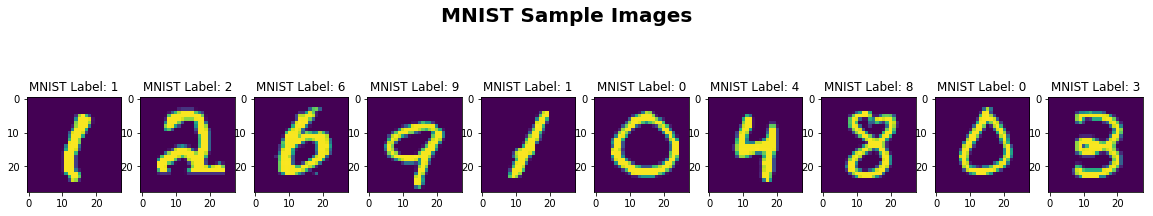

In [3]:
# 1.1
n_samples = 10
sample_indices = np.random.choice(train_dataset.train_data.size(0), n_samples)

sample_images = train_dataset.train_data[sample_indices,:,:].numpy()
sample_labels = [train_dataset.train_labels[x] for x in sample_indices]

# plot sample images
fig, ax = plt.subplots(1, n_samples, figsize=(20, 4))
plt.suptitle("MNIST Sample Images", fontsize=20, weight='heavy')
for i in range(n_samples):
    ax[i].imshow(sample_images[i])
    ax[i].set_title("MNIST Label: {}".format(sample_labels[i], weight='bold'))

plt.show()

In [4]:
# Regression Parent Class -- copied from lab
class Regression(object):
    def __init__(self):
        self.params = dict()
    
    def get_params(self, k):
        return self.params.get(k, None)
    
    def set_params(self, **kwargs):
        for k,v in kwargs.items():
            self.params[k] = v
              
    def fit(self, X, y): 
        raise NotImplementedError()
    
    def predict(self, X): 
        raise NotImplementedError()
    
    def score(self, X, y): 
        raise NotImplementedError()


class LRPyTorch(nn.Module): # PyTorch implementation of Logistic Regression -- copied from lab
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 10)

    def forward(self, x):
        x = self.l1(x)
        return x


In [5]:
class MNIST_Classifier(Regression): # MNIST Classifier extends Regression 
    def __init__(self, torch_model, learning_rate, batch_size, regularization, epochs): 
        super().__init__()
        
        # define model, loss, optimizer
        model = torch_model
        criterion = nn.CrossEntropyLoss() # Softmax = Cross Entropy
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=regularization)
        
        # Initialize the MNIST classifier's params
        self.set_params(optimizer=optimizer, 
                        learning_rate=learning_rate,
                        batch_size=batch_size,
                        model=model,
                        criterion=criterion,
                        epochs=epochs) 
        
    def predict(self, loader, dataset_type, save_misclassified=False):
        # dataset_type = 'Test' for test set; otherwise, load train_label or train_data
        dataset_labels = loader.dataset.test_labels if dataset_type == 'Test' else loader.dataset.train_labels
        dataset_images = loader.dataset.test_data if dataset_type == 'Test' else loader.dataset.train_data
        dataset_labels = dataset_labels.numpy()
        
        predictions = []
        correct_count = 0
        model = self.get_params('model')
        
        y_true = [] # labels enumerated
        X = [] # images enumerated
        for inputs, labels in loader:
            # forward pass
            inputs = Variable(inputs)
            inputs = inputs.view(-1, 28*28)
            outputs = model(inputs)
            
            # count correct
            pred = outputs.data.max(1)[1] # predicted class label, one-hot format
            correct_count += (pred == labels).sum()
            predictions += list(pred)
            
            # concatenate labels & images
            y_true += list(labels)
            X += list(inputs.numpy())
        
        predictions = np.array(predictions)
        y_true = np.array(y_true)
        X = np.array(X).reshape((len(X), 28, 28))
        
        # save 10 misclassified sample images
        if save_misclassified:
            mis_X = X[predictions != y_true]
            mis_preds = predictions[predictions != y_true]
            mis_y_true = y_true[predictions != y_true]
            self.save_misclassified(mis_X, mis_preds, mis_y_true)
            
        return predictions, y_true, correct_count
    
    def save_misclassified(self, mis_X, mis_preds, mis_y_true):
        # save all misclassified labels & preds
        self.set_params(all_mis_y_true = mis_y_true)
        self.set_params(all_mis_preds = mis_preds)
        
        # sample 10 misclassified images X
        sample_indices = np.random.choice(np.arange(mis_X.shape[0]), 10)
        
        # save to params the sampled misclassified X, pred/true label 
        self.set_params(misclassified_images = mis_X[sample_indices, :, :])
        self.set_params(misclassified_labels = mis_preds[sample_indices])
        self.set_params(misclassified_true_labels = mis_y_true[sample_indices])
    
    def viz_misclassified(self):
        # get the images and labels
        sample_images = self.get_params("misclassified_images")
        sample_labels = self.get_params("misclassified_labels")
        true_labels = self.get_params("misclassified_true_labels")

        fig, ax = plt.subplots(1, 10, figsize=(20, 4))
        plt.suptitle("Sample Misclassified Images", fontsize=20, weight='heavy')
        for i in range(10):
            ax[i].imshow(sample_images[i])
            ax[i].set_title("True Label: {}\n Classified: {}".format(true_labels[i], sample_labels[i]))
        plt.show()
        
    def score(self, loader, dataset_type, data_size, save_misclassified=False, verbose=False):
        _, _, correct_count = self.predict(loader, dataset_type, save_misclassified)
        if verbose:
            print('On {} set: Accuracy: {}/{} ({:.1f}%)\n'.format(dataset_type, correct_count, data_size, 
                                                              100.0*float(correct_count)/data_size))
        return (float(correct_count)/data_size)
        
    def fit(self, train_loader, train_size, validation_loader, validation_size):
        self.set_params(n_iter=int(np.ceil(train_size/self.get_params('batch_size'))))
        
        # reclaim parameters
        optimizer = self.get_params('optimizer')
        model = self.get_params('model')
        epochs = self.get_params('epochs')
        criterion = self.get_params('criterion')
        
        losses = []
        val_scores = [] # validation score at the end of each epoch
        for epoch in range(epochs):
            for batch_index, (inputs, labels) in enumerate(train_loader): # loop thru all batches per epoch
                # forward pass
                inputs, labels = Variable(inputs), Variable(labels)
                inputs = inputs.view(-1, 28*28)
                optimizer.zero_grad()
                outputs = model(inputs)
                
                # record loss & backward pass
                loss = criterion(outputs, labels)
                losses.append(loss.data[0].numpy().reshape([1])[0])
                loss.backward()
                optimizer.step()
            
            val_score = self.score(validation_loader, 'Validation', validation_size) 
            val_scores.append(val_score)
            
            print('{} epoch fitted'.format(epoch+1), end='\r')
                
        self.set_params(training_losses=losses) # set params: 'training_losses'
        self.set_params(validation_scores=val_scores) # validation score by the end of each epoch
        
        return self

    def viz_training_loss(self):
        losses = self.get_params('training_losses')
        n_iter = self.get_params('n_iter')
        epochs = self.get_params('epochs')
        fig, axes = plt.subplots(nrows=1, ncols=epochs, figsize=(20, 5), sharex=True, sharey=True)
        for i in range(epochs):
            if i == epochs:
                axes[i].plot(range(len(losses[i*n_iter:])), losses[i*n_iter:])
            else:
                axes[i].plot(range(n_iter), losses[i*n_iter:(i+1)*n_iter])
            axes[i].set_title('ep{}'.format(i))
            if i % 2 == 1:
                axes[i].axvspan(-10, n_iter, facecolor='gray', alpha=0.2)
        plt.subplots_adjust(wspace=0)
        plt.show()

In [6]:
# 1.2
# split out validation set
indices = list(range(len(train_dataset)))
val_split = 10000
batch_size = 256
lr = LRPyTorch()

# Random, non-contiguous split
validation_idx = np.random.choice(indices, size=val_split, replace=False)
train_idx = np.array(list(set(indices) - set(validation_idx)))
train_size, validation_size, test_size = train_idx.shape[0], validation_idx.shape[0], len(test_dataset)
print('Train size = {}, Validation size = {}, Test size = {}'.format(train_size, 
                                                                     validation_size, 
                                                                     test_size))

# train & validation samplers, test set does not require shuffling
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

# train, validation & test loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=validation_size, sampler=validation_sampler)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_size, shuffle=False)

Train size = 50000, Validation size = 10000, Test size = 10000


In [7]:
# 1.3, 1.4
# fit the classifier
mnist_clf = MNIST_Classifier(lr, learning_rate=0.1, batch_size=batch_size, regularization=0.01, epochs=30)
mnist_clf = mnist_clf.fit(train_loader, train_size, validation_loader, validation_size)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [8]:
# print scores
_ = mnist_clf.score(train_loader, 'Train', train_size, save_misclassified=False, verbose=True)
_ = mnist_clf.score(validation_loader, 'Validation', validation_size, save_misclassified=False, verbose=True)
_ = mnist_clf.score(test_loader, 'Test', test_size, save_misclassified=False, verbose=True)

On Train set: Accuracy: 45704/50000 (91.4%)

On Validation set: Accuracy: 9049/10000 (90.5%)

On Test set: Accuracy: 9122/10000 (91.2%)



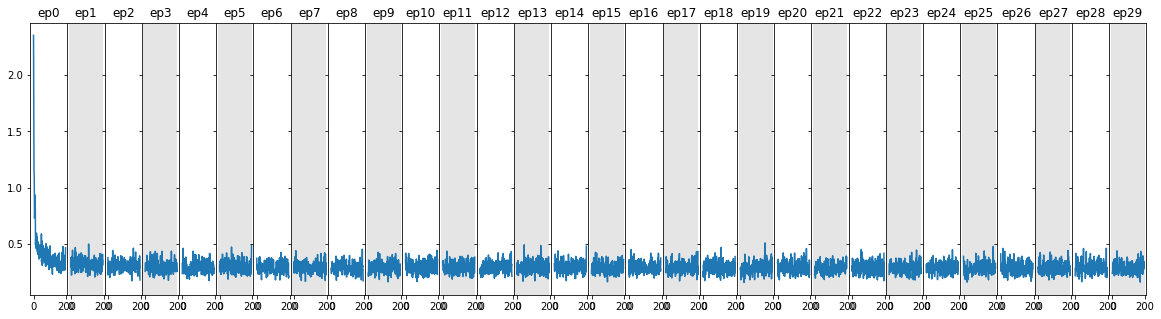

In [9]:
# 1.5
# plot training loss
mnist_clf.viz_training_loss()

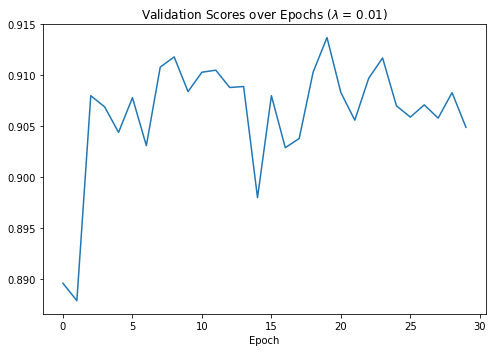

In [10]:
# 1.6
# plot validation score over epochs - lambda = 0.01
validation_scores = mnist_clf.get_params('validation_scores')
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
pd.Series(validation_scores).plot(title=r'Validation Scores over Epochs ($\lambda$ = 0.01)', ax=ax)
ax.set_xlabel('Epoch')
plt.tight_layout()

In [18]:
# 1.6
# Different regularization lambdas
reg_params = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0.00001])
val_scores_arr = []
final_val_score_arr = []

for reg in reg_params:
    print('lambda = {}'.format(reg))
    # fit a classifier for this lambda
    _clf = MNIST_Classifier(lr, learning_rate=0.1, batch_size=batch_size, regularization=reg, epochs=30)
    _clf.fit(train_loader, train_size, validation_loader, validation_size)
    
    # record the validation scores over epochs of this classifier
    val_scores_arr.append(_clf.get_params('validation_scores'))
    
    # record the final validation score of this classifier
    final_val_score_arr.append(_clf.score(validation_loader, 'Validation', validation_size))


lambda = 1.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


lambda = 0.1ted
lambda = 0.01ed
lambda = 0.001d
lambda = 0.0001
lambda = 1e-05d


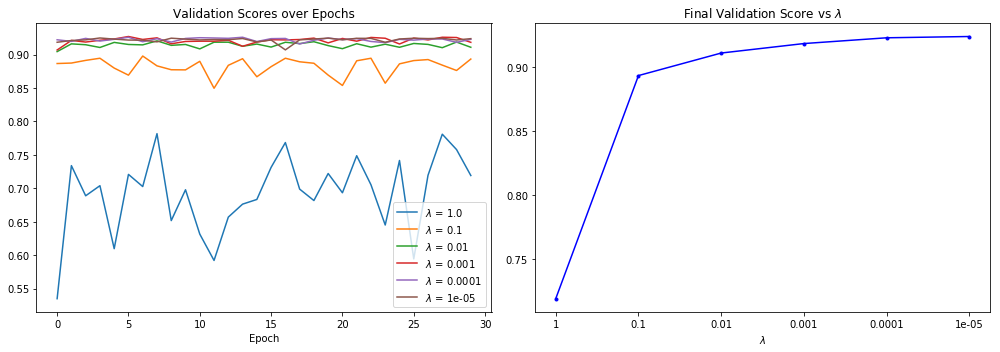

In [24]:
# 1.7
# find the best regularization parameter using the validation set

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for _i, _val_scores in enumerate(val_scores_arr):
    # plot validation scores over epochs for this classifier
    axes[0].plot(_val_scores, label=r'$\lambda$ = {}'.format(reg_params[_i]))

axes[0].set_xlabel('Epoch')
axes[0].set_title('Validation Scores over Epochs')
axes[0].legend()

axes[1].plot(final_val_score_arr, '.-', c='b')
axes[1].set_xlabel(r'$\lambda$')
axes[1].set_title(r'Final Validation Score vs $\lambda$')
axes[1].set_xticklabels([-1, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001])

plt.tight_layout()

### Answer 1.7
When to stop the training for each of the different values of $\lambda$? 

- Based on the plots of **validation scores over epochs** with different regularization parameter $\lambda$'s, all classifiers with $\lambda \leq 0.1$ converged relatively quicly (within the first 5 epochs). With $\lambda = 1$, the classifier had poorer validation performance with larger fluctuation.

- Based on the plot of **final validation accuracies vs different $\lambda$'s**, the smaller the regularization, the better validation performance we can get. But the performance improvements after $\lambda = 0.001$ became less obvious. In this case, we can see overfitting is not a major problem of logistic regression modelling. Validation/test set has almost the same level of accuracy as training set.

In [7]:
# fit a clf with the best selected lambda 
best_lr_clf = MNIST_Classifier(lr, learning_rate=0.1, batch_size=batch_size, regularization=0.001, epochs=30)
best_lr_clf.fit(train_loader, train_size, validation_loader, validation_size)

# predict on the training & test set
train_acc = best_lr_clf.score(train_loader, 'Train', train_size, save_misclassified=False, verbose=True)
test_acc = best_lr_clf.score(test_loader, 'Test', test_size, save_misclassified=False, verbose=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


On Train set: Accuracy: 46437/50000 (92.9%)

On Test set: Accuracy: 9231/10000 (92.3%)



### Answer 1.8 - LR misclassification on train set

In [8]:
# 1.8 - Training set
train_preds, train_labels, train_correct_count = best_lr_clf.predict(train_loader, 'Train', 
                                                                     save_misclassified=True)

# misclassification counts
df_mis_train = pd.DataFrame(pd.Series(train_labels[train_labels != train_preds], name='digit'))
df_mis_train['count'] = np.ones((len(df_mis_train),)).astype(int)
df_mis_train = df_mis_train.groupby([
    'digit']
)['count'].agg([sum]).rename(columns={'sum':'mis_count'}).reset_index()

# digit counts
df_digit_train = pd.DataFrame(pd.Series(train_labels, name='digit'))
df_digit_train['count'] = np.ones((len(df_digit_train),)).astype(int)
df_digit_train = df_digit_train.groupby([
    'digit']
)['count'].agg([sum]).rename(columns={'sum':'count'}).reset_index()

df_train_res = df_digit_train.merge(df_mis_train, on='digit', how='inner').set_index('digit')
df_train_res['mis_percent'] = df_train_res['mis_count'] / df_train_res['count'] * 100
df_train_res.sort_values(['mis_percent'], ascending=False)

,count,mis_count,mis_percent
digit,,,
5,4509,604,13.395431
3,5164,658,12.742060
2,4955,442,8.920283
9,4959,417,8.408953
7,5163,339,6.565950
8,4893,289,5.906397
4,4911,281,5.721849
6,4906,211,4.300856
1,5615,192,3.419412


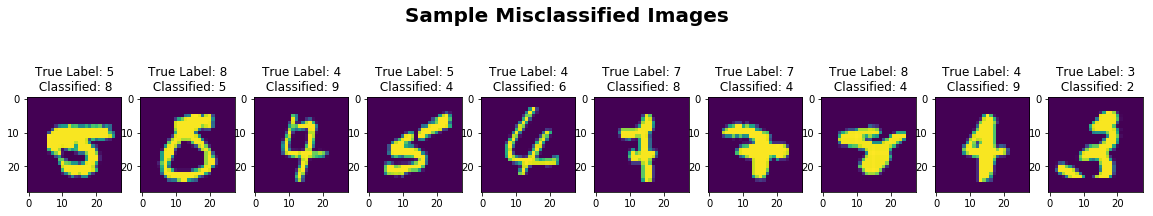

In [9]:
best_lr_clf.viz_misclassified()

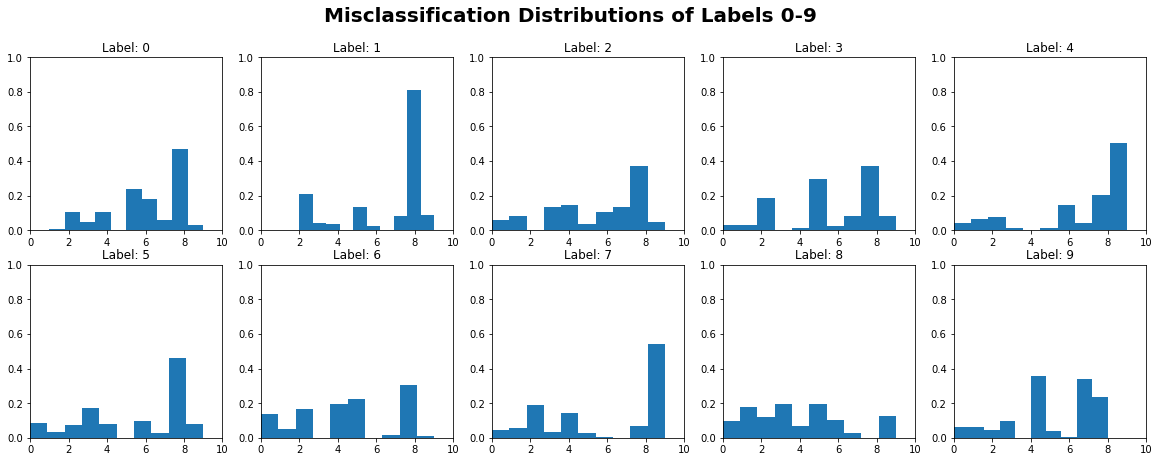

In [10]:
mis_dist = [[] for i in range(10)]
for _i, digit in enumerate(best_lr_clf.get_params('all_mis_y_true')):
    mis_dist[int(digit)].append(best_lr_clf.get_params('all_mis_preds')[_i])

fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 7))
plt.suptitle('Misclassification Distributions of Labels 0-9', fontsize=20, weight='heavy')

for i in range(5):
    ax1[i].hist(mis_dist[i], normed = True)
    ax1[i].set_title('Label: {}'.format(i))
    ax1[i].set_xlim(0, 10)
    ax1[i].set_ylim(0, 1)
    ax2[i].hist(mis_dist[i + 5], normed = True)
    ax2[i].set_title('Label: {}'.format(i+5))
    ax2[i].set_xlim(0, 10)
    ax2[i].set_ylim(0, 1)

### Answer 1.8 - LR misclassification on test set

In [11]:
# 1.8 - Test set
test_preds, test_labels, test_correct_count = best_lr_clf.predict(test_loader, 'Test', save_misclassified=True)

# misclassification counts
df_mis_test = pd.DataFrame(pd.Series(test_labels[test_labels != test_preds], name='digit'))
df_mis_test['count'] = np.ones((len(df_mis_test),)).astype(int)
df_mis_test = df_mis_test.groupby([
    'digit']
)['count'].agg([sum]).rename(columns={'sum':'mis_count'}).reset_index()

# digit counts
df_digit_test = pd.DataFrame(pd.Series(test_labels, name='digit'))
df_digit_test['count'] = np.ones((len(df_digit_test),)).astype(int)
df_digit_test = df_digit_test.groupby([
    'digit']
)['count'].agg([sum]).rename(columns={'sum':'count'}).reset_index()

df_test_res = df_digit_test.merge(df_mis_test, on='digit', how='inner').set_index('digit')
df_test_res['mis_percent'] = df_test_res['mis_count'] / df_test_res['count'] * 100
df_test_res.sort_values(['mis_percent'], ascending=False)

,count,mis_count,mis_percent
digit,,,
5,892,127,14.237668
3,1010,118,11.683168
2,1032,112,10.852713
9,1009,89,8.820614
7,1028,86,8.365759
8,974,71,7.289528
4,982,65,6.619145
6,958,48,5.010438
1,1135,35,3.083700


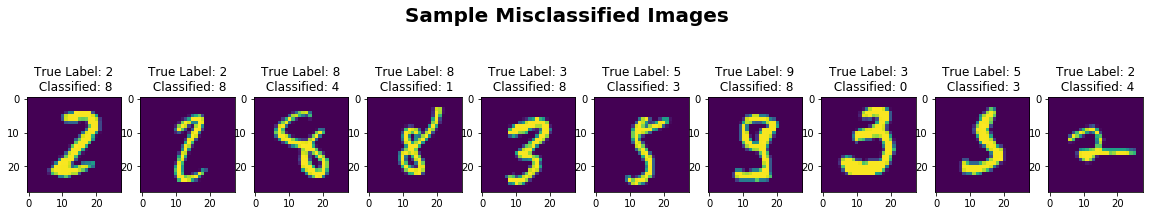

In [12]:
best_lr_clf.viz_misclassified()

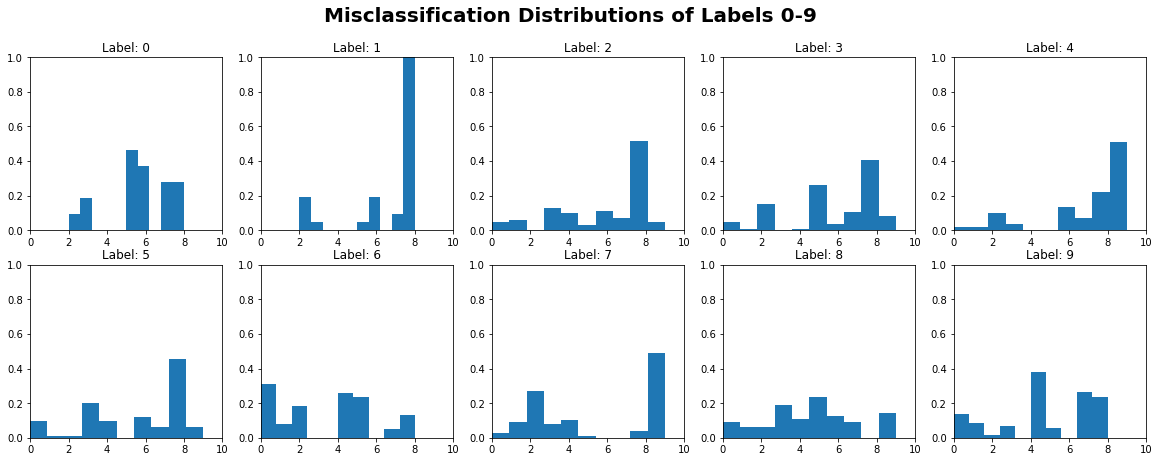

In [13]:
mis_dist = [[] for i in range(10)]
for _i, digit in enumerate(best_lr_clf.get_params('all_mis_y_true')):
    mis_dist[int(digit)].append(best_lr_clf.get_params('all_mis_preds')[_i])

fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 7))
plt.suptitle('Misclassification Distributions of Labels 0-9', fontsize=20, weight='heavy')

for i in range(5):
    ax1[i].hist(mis_dist[i], normed = True)
    ax1[i].set_title('Label: {}'.format(i))
    ax1[i].set_xlim(0, 10)
    ax1[i].set_ylim(0, 1)
    ax2[i].hist(mis_dist[i + 5], normed = True)
    ax2[i].set_title('Label: {}'.format(i+5))
    ax2[i].set_xlim(0, 10)
    ax2[i].set_ylim(0, 1)

### Answer 1.8 
Digit 5, 3, 2, 9, 7, 8, 4 are more likelily to be misclassified than other digits.

---

<div class="answer-separator">
------------------------
</div>

## Question 2: MNIST MLP!  Find out what that means to me.  MNIST MLP!  Take care, TCB!

The multilayer perceptron can be understood as a logistic regression classifier in which the input is first transformed using a learnt non-linear transformation. The non-linear transformation is often chosen to be either the logistic function or the $\tanh$ function or the RELU function, and its purpose is to project the data into a space where it becomes linearly separable. The output of this so-called hidden layer is then passed to the logistic regression graph that we have constructed in the first problem. 

![](http://deeplearning.net/tutorial/_images/mlp.png)

We'll construct a model with **1 hidden layer**. That is, you will have an input layer, then a hidden layer with the nonlinearity, and finally an output layer with cross-entropy loss (or equivalently log-softmax activation with a negative log likelihood loss).

2.1. Using a similar architecture as in Question 1 and the same training, validation and test sets, build a PyTorch model for the multilayer perceptron. Use the $\tanh$ function as the non-linear activation function. 

2.2. The initialization of the weights matrix for the hidden layer must assure that the units (neurons) of the perceptron operate in a regime where information gets propagated. For the $\tanh$ function, you may find it advisable to initialize with the interval $\left[-\sqrt{\frac{6}{\text{fan}_{in}+\text{fan}_{out}}},\sqrt{\frac{6}{\text{fan}_{in}+\text{fan}_{out}}}\right]$, where $\text{fan}_{in}$ is the number of units in the $(i-1)$-th layer, and $\text{fan}_{out}$ is the number of units in the i-th layer.  This is known as **Xavier Initialization**.  Use Xavier Initialization to initialize your MLP.  Feel free to use PyTorch's in-built Xavier Initialization methods.

2.3. Using $\lambda = 0.01$ to compare with Question 1, experiment with the learning rate (try 0.1 and 0.01 for example), batch size (use 64, 128 and 256) and the number of units in your hidden layer (use between 25 and 200 units). For what combination of these parameters do you obtain the highest validation accuracy?  You may want to start with 20 epochs for running time and experiment a bit to make sure that your models reach convergence. 

2.4. For your best combination plot the cross-entropy loss on the training set as a function of iteration.

2.5. For your best combination use classification accuracy to evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.

2.6. Select what you consider the best set of parameters and predict the labels of the test set. Compare your predictions with the given labels. What classification accuracy do you obtain on the training and test sets?

2.7. How does your test accuracy compare to that of the logistic regression classifier in Question 1?  Compare best parameters for both models.

2.8. What classes are most likely to be misclassified? Plot some misclassified training and test set images.


**Gratuitous Titular Reference**:  Respect, originally performed by Otis Redding, became a huge hit and an anthem for the recently departed "Queen of Soul" Aretha Franklin.  Respect is often credited with popularizing the word usages "propers" (a synonym for respect) and "sock it to me".

In [14]:
# 2.1, 2.2
class MLPPyTorch(nn.Module):
    def __init__(self, N_hidden):
        super().__init__()
        self.l1 = nn.Linear(784, N_hidden)
        
        # Xavier Initialization
        torch.nn.init.xavier_uniform_(self.l1.weight)
        torch.nn.init.constant_(self.l1.bias, 0.)
        
        self.l2 = nn.Linear(N_hidden, 10)

    def forward(self, x):
        x = self.l1(x) 
        x = torch.tanh(x) 
        x = self.l2(x)
        return x

In [18]:
# 2.3 grid search best hyper parameters
learning_rates =  [0.1, 0.01]
batch_sizes = [64, 128, 256] 
N_hiddens = [25, 50, 100, 150, 200]
val_scores_res = []

for eta in learning_rates:
    for bs in batch_sizes:
        for nh in N_hiddens:
            print('eta = {}, bs = {}, nh = {}'.format(eta, bs, nh))
            mlp = MLPPyTorch(nh)
            mlp_clf = MNIST_Classifier(mlp, learning_rate=eta, batch_size=bs, regularization=0.01, epochs=30)
            batch_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, sampler=train_sampler)
            mlp_clf.fit(batch_train_loader, train_size, validation_loader, validation_size)
            val_scores_res.append(mlp_clf.get_params('validation_scores'))
            

eta = 0.1, bs = 64, nh = 25


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


eta = 0.1, bs = 64, nh = 50
eta = 0.1, bs = 64, nh = 100
eta = 0.1, bs = 64, nh = 150
eta = 0.1, bs = 64, nh = 200
eta = 0.1, bs = 128, nh = 25
eta = 0.1, bs = 128, nh = 50
eta = 0.1, bs = 128, nh = 100
eta = 0.1, bs = 128, nh = 150
eta = 0.1, bs = 128, nh = 200
eta = 0.1, bs = 256, nh = 25
eta = 0.1, bs = 256, nh = 50
eta = 0.1, bs = 256, nh = 100
eta = 0.1, bs = 256, nh = 150
eta = 0.1, bs = 256, nh = 200
eta = 0.01, bs = 64, nh = 25
eta = 0.01, bs = 64, nh = 50
eta = 0.01, bs = 64, nh = 100
eta = 0.01, bs = 64, nh = 150
eta = 0.01, bs = 64, nh = 200
eta = 0.01, bs = 128, nh = 25
eta = 0.01, bs = 128, nh = 50
eta = 0.01, bs = 128, nh = 100
eta = 0.01, bs = 128, nh = 150
eta = 0.01, bs = 128, nh = 200
eta = 0.01, bs = 256, nh = 25
eta = 0.01, bs = 256, nh = 50
eta = 0.01, bs = 256, nh = 100
eta = 0.01, bs = 256, nh = 150
eta = 0.01, bs = 256, nh = 200


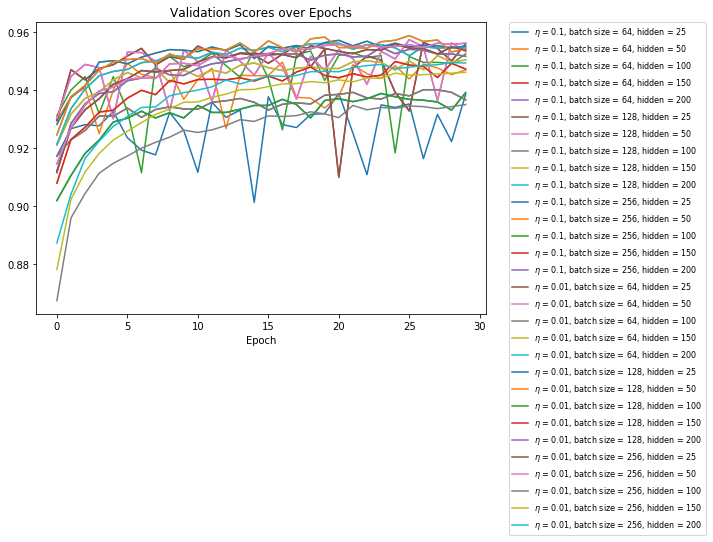

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for _a, eta in enumerate(learning_rates):
    for _b, bs in enumerate(batch_sizes):
        for _c, nh in enumerate(N_hiddens):
            ax.plot(val_scores_res[_a*len(batch_sizes) + _b*len(N_hiddens) + _c], 
                    label=r'$\eta$ = {}, batch size = {}, hidden = {}'.format(eta, bs, nh))

ax.set_xlabel('Epoch')
ax.set_title('Validation Scores over Epochs')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)

plt.tight_layout()

In [20]:
np.array(val_scores_res).shape

(30, 30)

In [21]:
# best params combination's 1D index
np.argmax(np.array(val_scores_res)[:, -10:].mean(axis=1))

9

### Answer 2.3
The highest validation accuracy with $\lambda = 0.01$ was achieved with the following combination of hyper parameters:

- `learning_rate = 0.1`
- `batch_size = 128`
- `N_hidden = 200`

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


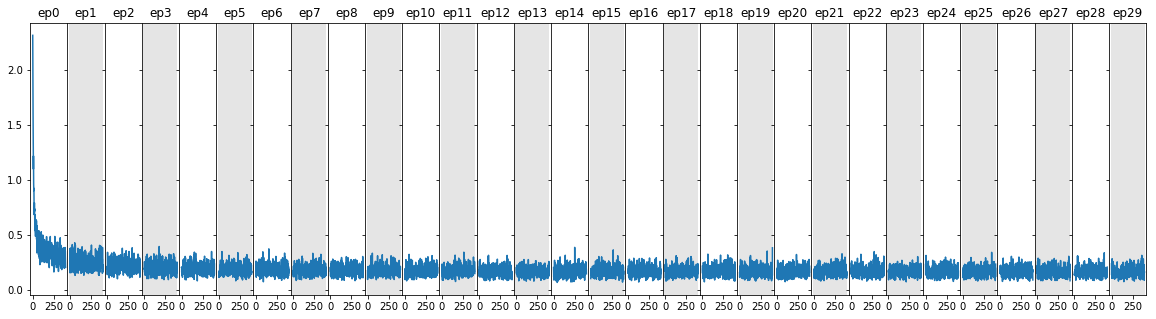

In [22]:
# 2.4 
# best model cross-entropy loss over iterations
best_mlp_clf = MNIST_Classifier(MLPPyTorch(200), learning_rate=0.1, batch_size=128, 
                               regularization=0.01, epochs=30) 
batch_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, sampler=train_sampler)
best_mlp_clf.fit(batch_train_loader, train_size, validation_loader, validation_size)
best_mlp_clf.viz_training_loss()

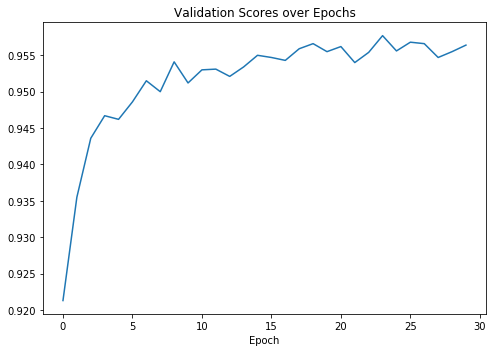

In [23]:
# 2.5 
# plot final iteration validation score over epochs
validation_scores = best_mlp_clf.get_params('validation_scores')

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
pd.Series(validation_scores).plot(title='Validation Scores over Epochs', ax=ax)
ax.set_xlabel('Epoch')
plt.tight_layout()

In [24]:
# 2.6 
# accuracy on train & test set
train_acc = best_mlp_clf.score(train_loader, 'Train', train_size, save_misclassified=False, verbose=True)
test_acc = best_mlp_clf.score(test_loader, 'Test', test_size, save_misclassified=False, verbose=True)

On Train set: Accuracy: 48086/50000 (96.2%)

On Test set: Accuracy: 9589/10000 (95.9%)



### Answer 2.7 
With $\lambda = 0.01$, the best test accuracies of the 2 models are:
- Logistic regression: 91.2%
- Multi-layer perceptron: 95.9%

---
### Answer 2.8 - MLP misclassification on train set:

In [25]:
# 2.8 - Training set
train_preds, train_labels, train_correct_count = best_mlp_clf.predict(train_loader, 'Train', 
                                                                     save_misclassified=True)

# misclassification counts
df_mis_train = pd.DataFrame(pd.Series(train_labels[train_labels != train_preds], name='digit'))
df_mis_train['count'] = np.ones((len(df_mis_train),)).astype(int)
df_mis_train = df_mis_train.groupby([
    'digit']
)['count'].agg([sum]).rename(columns={'sum':'mis_count'}).reset_index()

# digit counts
df_digit_train = pd.DataFrame(pd.Series(train_labels, name='digit'))
df_digit_train['count'] = np.ones((len(df_digit_train),)).astype(int)
df_digit_train = df_digit_train.groupby([
    'digit']
)['count'].agg([sum]).rename(columns={'sum':'count'}).reset_index()

df_train_res = df_digit_train.merge(df_mis_train, on='digit', how='inner').set_index('digit')
df_train_res['mis_percent'] = df_train_res['mis_count'] / df_train_res['count'] * 100
df_train_res.sort_values(['mis_percent'], ascending=False)

,count,mis_count,mis_percent
digit,,,
3,5164,298,5.770720
5,4509,253,5.611000
8,4893,260,5.313713
9,4959,230,4.638032
4,4911,216,4.398290
2,4955,184,3.713421
7,5163,166,3.215185
6,4906,104,2.119853
0,4925,98,1.989848


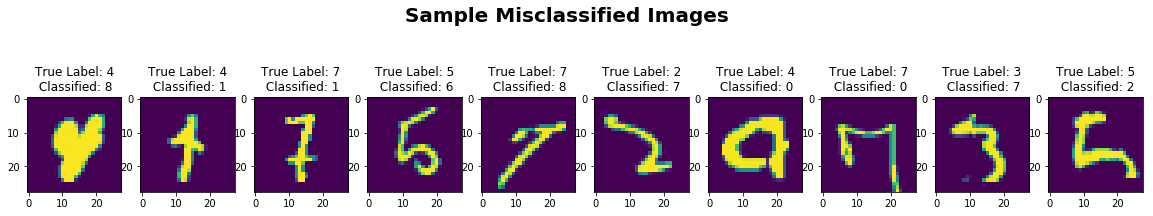

In [26]:
best_mlp_clf.viz_misclassified()

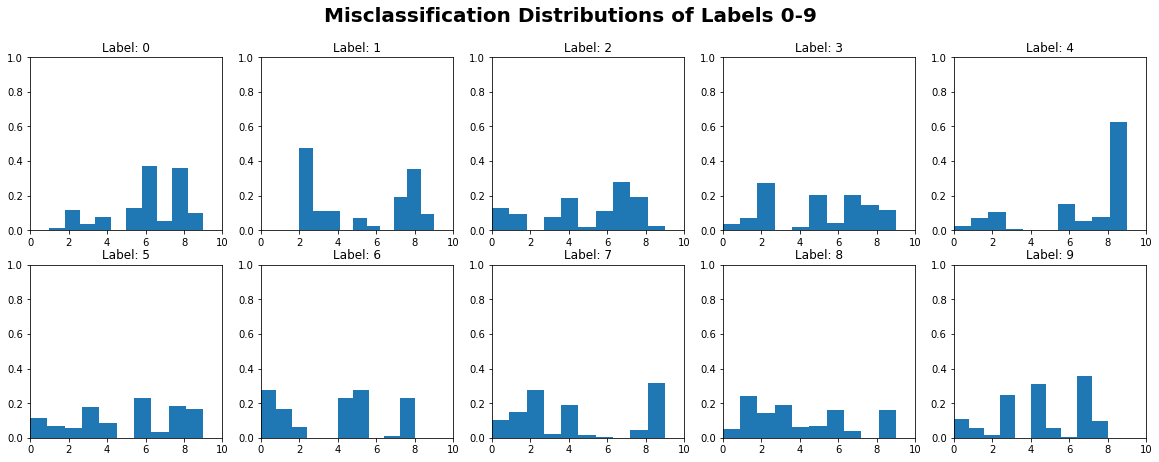

In [27]:
mis_dist = [[] for i in range(10)]
for _i, digit in enumerate(best_mlp_clf.get_params('all_mis_y_true')):
    mis_dist[int(digit)].append(best_mlp_clf.get_params('all_mis_preds')[_i])

fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 7))
plt.suptitle('Misclassification Distributions of Labels 0-9', fontsize=20, weight='heavy')

for i in range(5):
    ax1[i].hist(mis_dist[i], normed = True)
    ax1[i].set_title('Label: {}'.format(i))
    ax1[i].set_xlim(0, 10)
    ax1[i].set_ylim(0, 1)
    ax2[i].hist(mis_dist[i + 5], normed = True)
    ax2[i].set_title('Label: {}'.format(i+5))
    ax2[i].set_xlim(0, 10)
    ax2[i].set_ylim(0, 1)

### Answer 2.8 - MLP misclassification on test set

In [28]:
# 2.8 - Test set
test_preds, test_labels, test_correct_count = best_mlp_clf.predict(test_loader, 'Test', save_misclassified=True)

# misclassification counts
df_mis_test = pd.DataFrame(pd.Series(test_labels[test_labels != test_preds], name='digit'))
df_mis_test['count'] = np.ones((len(df_mis_test),)).astype(int)
df_mis_test = df_mis_test.groupby([
    'digit']
)['count'].agg([sum]).rename(columns={'sum':'mis_count'}).reset_index()

# digit counts
df_digit_test = pd.DataFrame(pd.Series(test_labels, name='digit'))
df_digit_test['count'] = np.ones((len(df_digit_test),)).astype(int)
df_digit_test = df_digit_test.groupby([
    'digit']
)['count'].agg([sum]).rename(columns={'sum':'count'}).reset_index()

df_test_res = df_digit_test.merge(df_mis_test, on='digit', how='inner').set_index('digit')
df_test_res['mis_percent'] = df_test_res['mis_count'] / df_test_res['count'] * 100
df_test_res.sort_values(['mis_percent'], ascending=False)

,count,mis_count,mis_percent
digit,,,
5,892,60,6.726457
8,974,53,5.441478
9,1009,52,5.153617
4,982,50,5.091650
7,1028,49,4.766537
2,1032,46,4.457364
3,1010,43,4.257426
6,958,31,3.235908
1,1135,15,1.321586


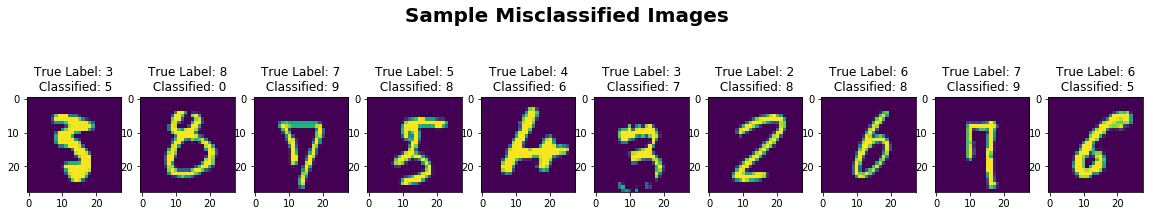

In [29]:
best_mlp_clf.viz_misclassified()

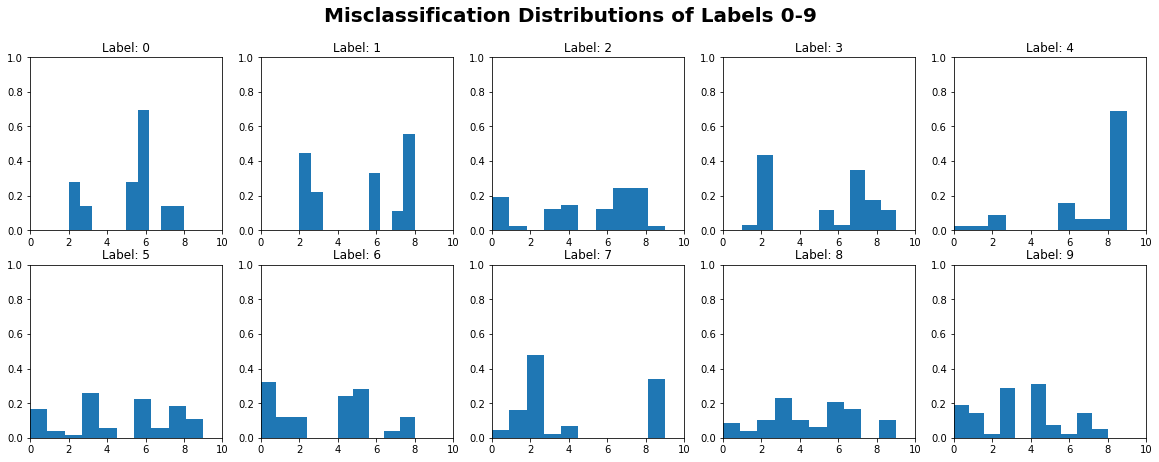

In [30]:
mis_dist = [[] for i in range(10)]
for _i, digit in enumerate(best_mlp_clf.get_params('all_mis_y_true')):
    mis_dist[int(digit)].append(best_mlp_clf.get_params('all_mis_preds')[_i])

fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 7))
plt.suptitle('Misclassification Distributions of Labels 0-9', fontsize=20, weight='heavy')

for i in range(5):
    ax1[i].hist(mis_dist[i], normed = True)
    ax1[i].set_title('Label: {}'.format(i))
    ax1[i].set_xlim(0, 10)
    ax1[i].set_ylim(0, 1)
    ax2[i].hist(mis_dist[i + 5], normed = True)
    ax2[i].set_title('Label: {}'.format(i+5))
    ax2[i].set_xlim(0, 10)
    ax2[i].set_ylim(0, 1)

### Answer 2.8 
Digit 5, 3, 2, 9, 7, 8, 4 are still more likelily to be misclassified than other digits. But their misclassification frequencies of the 2-layer MLP model are much lower ($\approx$6%) than those of the 1-layer Logistic Regression model ($\approx$14%)

---

<div class="answer-separator">
------------------------
</div>